# Laboraroty work 1
__Reporter: Skorik Sergey__

## Variant 5

__Description:__
Visualize empricial distribution of model parameters with dependence on the $p$ in $L^p$ regularization. Model: logistic regression or 1-layer neural network. Dataset: sklearn dataset.

## Imports

### installing dependencies

In [ ]:
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 5.2 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 


In [ ]:
# import jax main modules for building and training neural networks
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.nn import relu, log_softmax
from jax.example_libraries.stax import elementwise, serial, Dense
from optax import adam, apply_updates

# import sklearn dataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

#import plot functions
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#import util functions
import numpy as np
from time import time
from jax.tree_util import Partial
import pandas as pd

## Define visualize settings

In [ ]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
palette = sns.color_palette('Set2')

## Loading the data

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

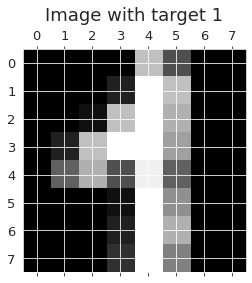

In [ ]:
X, Y = load_digits(return_X_y=True)
plt.gray()
plt.figure(figsize=(8, 8)) 
plt.matshow(X[42].reshape(8, 8))
plt.title(f"Image with target {Y[42]}", y=1.1)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Hyperparameters

In [ ]:
config = {}
config['hidden_neurons'] = 32
config['learning_rate'] = 0.001
config['num_epochs'] = 50
config['batch_size'] = 128
config['n_targets'] = 10
config['feature_dim'] = 64

## Initializing a model

In [ ]:
init_random_params, predict = serial(
    Dense(config['hidden_neurons']),
    elementwise(relu),
    Dense(config['n_targets']),
)

# Prepare a random number generator to initialize the model
rng = random.PRNGKey(0)

# Initialize the model
_, init_params = init_random_params(rng, input_shape=(-1, config['feature_dim']))

## Initializing an optimizer

In [ ]:
optimizer = adam(config['learning_rate'])
opt_state = optimizer.init(init_params)

## Constructing metric functions (loss and accuracy)

In [ ]:
def regularization_row(row, p):
    return jnp.linalg.norm(row, p)


def loss(params, images, targets, p, alpha):
    """ Cross-entropy loss based on predicted labels in the batch """
    output = predict(params, images)
    m = targets.shape[0]
    log_p = log_softmax(output)
    log_likelihood = -log_p[np.arange(m), targets]

    regularization = jnp.array(0.0)
    for weights in params:
        if weights:
            w, b = weights
            regularization += jnp.sum(vmap(regularization_row, in_axes=(0, None))(w, p))
            regularization += regularization_row(b, p)
    
    return jnp.mean(log_likelihood) + 0.5 * alpha / m * regularization


def accuracy(params, images, targets):
    """ Compute accuracy as a percentage of correct labels in batch """
    output = predict(params, images)
    
    predicted_class = jnp.argmax(output, axis=1)

    return jnp.mean(predicted_class == targets)

## Create dataloader

In [ ]:
class Dataloader:
    def __init__(self, X, y, batch_size, shuffle=True, normalize=True, drop_last=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.normalize = normalize
        self.drop_last = drop_last
        self.order = jnp.arange(X.shape[0])
        if shuffle:
            self.order = random.permutation(random.PRNGKey(42), self.order)
        self.order = list(self.order)

    def __iter__(self):
        self.step = 0
        return self

    def __next__(self):
        if (self.step + 1) * self.batch_size < len(self.order):
            idxs = self.order[self.step * self.batch_size:(self.step+1) * self.batch_size]
        elif self.step * self.batch_size < len(self.order):
            if not self.drop_last:
                idxs = [self.order[self.step * self.batch_size:]]
            else:
                raise StopIteration
        else:
            raise StopIteration
        X_batch = self.X[idxs]
        y_batch = self.y[idxs]
        if self.normalize:
            X_batch = (X_batch - X_batch.mean()) / X_batch.std()
        self.step += 1
        return X_batch, y_batch

    def __len__(self):
        return len(self.X) // self.batch_size + int(not self.drop_last)

In [ ]:
train_dataloader = Dataloader(X_train, y_train, config['batch_size'])
test_dataloader = Dataloader(X_test, y_test, config['batch_size'], shuffle=False, normalize=False)

(128, 64)
(128,)


<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

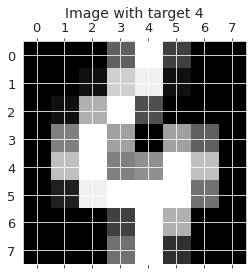

In [ ]:
#Checking the operation of the dataloader
for X_batch, y_batch in train_dataloader:
    print(X_batch.shape)
    print(y_batch.shape)
    plt.gray()
    plt.figure(figsize=(8, 8)) 
    plt.matshow(X_batch[56].reshape(8, 8))
    plt.title(f"Image with target {y_batch[56]}", fontsize=14, y=1.08)
    plt.show()
    break

## Training loop

In [ ]:
from tqdm import tqdm


@Partial(jit, static_argnames=('p', 'alpha'))
def _train_step(params, optimizer_state, images, targets, p, alpha):
    grads = grad(loss)(params, images, targets, p, alpha)
    updates, opt_state = optimizer.update(grads, optimizer_state, params)
    return apply_updates(params, updates), opt_state

class Trainer:

    def __init__(self, params, optimizer_state, p, alpha, num_targets=config['n_targets']):
        self.params = params
        self.opt_state = optimizer_state
        
        if p == 'inf':
            self.p = jnp.inf
        else:
            self.p = p
        self.alpha = alpha
        self.num_targets = num_targets

    def _epoch_step(self, dataloader):
        for X_batch, y_batch in dataloader:
            params, opt_state = _train_step(self.params, self.opt_state, X_batch, y_batch, self.p, self.alpha)
            self.params = params
            self.opt_state = opt_state

        train_acc = accuracy(self.params, X_train, y_train)
        test_acc = accuracy(self.params, X_test, y_test)

        train_loss = loss(self.params, X_train, y_train, self.p, self.alpha)
        test_loss = loss(self.params, X_test, y_test, self.p, self.alpha)

        return (train_acc, test_acc), (train_loss, test_loss)

    def train(self, dataloader, n_epoch, verbose=False):
        start_time = time()
        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        for epoch in range(n_epoch):
            accs, losses = self._epoch_step(dataloader)
            train_acc, test_acc = accs
            train_loss, test_loss = losses
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            if verbose:
                print(
                    'epoch: {:>2}, train acc: {:.4f}, test acc: {:.4f}, train loss: {:.4f}, test loss: {:.4f}, time: {:.4f}' \
                        .format(epoch + 1, train_acc, test_acc, 
                                train_loss, test_loss, time() - start_time)
                )
        return self.params, (train_losses, test_losses), (train_accs, test_accs)

In [ ]:
trainer = Trainer(init_params, opt_state, p=2, alpha=1.0)
trained_params, losses, accs = trainer.train(train_dataloader, config['num_epochs'], verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


epoch:  1, train acc: 0.1969, test acc: 0.1778, train loss: 6.7019, test loss: 7.3878, time: 3.6899
epoch:  2, train acc: 0.2742, test acc: 0.2556, train loss: 5.1793, test loss: 5.7783, time: 3.7538
epoch:  3, train acc: 0.3688, test acc: 0.3583, train loss: 4.1092, test loss: 4.6123, time: 3.8129
epoch:  4, train acc: 0.4614, test acc: 0.4417, train loss: 3.3369, test loss: 3.7635, time: 3.8709
epoch:  5, train acc: 0.5560, test acc: 0.5389, train loss: 2.6042, test loss: 2.9667, time: 3.9618
epoch:  6, train acc: 0.6555, test acc: 0.6389, train loss: 2.0250, test loss: 2.3149, time: 4.0168
epoch:  7, train acc: 0.7196, test acc: 0.7167, train loss: 1.6618, test loss: 1.9132, time: 4.0746
epoch:  8, train acc: 0.7676, test acc: 0.7694, train loss: 1.3864, test loss: 1.6524, time: 4.1552
epoch:  9, train acc: 0.8017, test acc: 0.7833, train loss: 1.1862, test loss: 1.4674, time: 4.2081
epoch: 10, train acc: 0.8225, test acc: 0.8000, train loss: 1.0416, test loss: 1.3277, time: 4.2738


### plot results

Text(0.5, 1.02, 'L_2 regularization with alpha=1.0 training results')

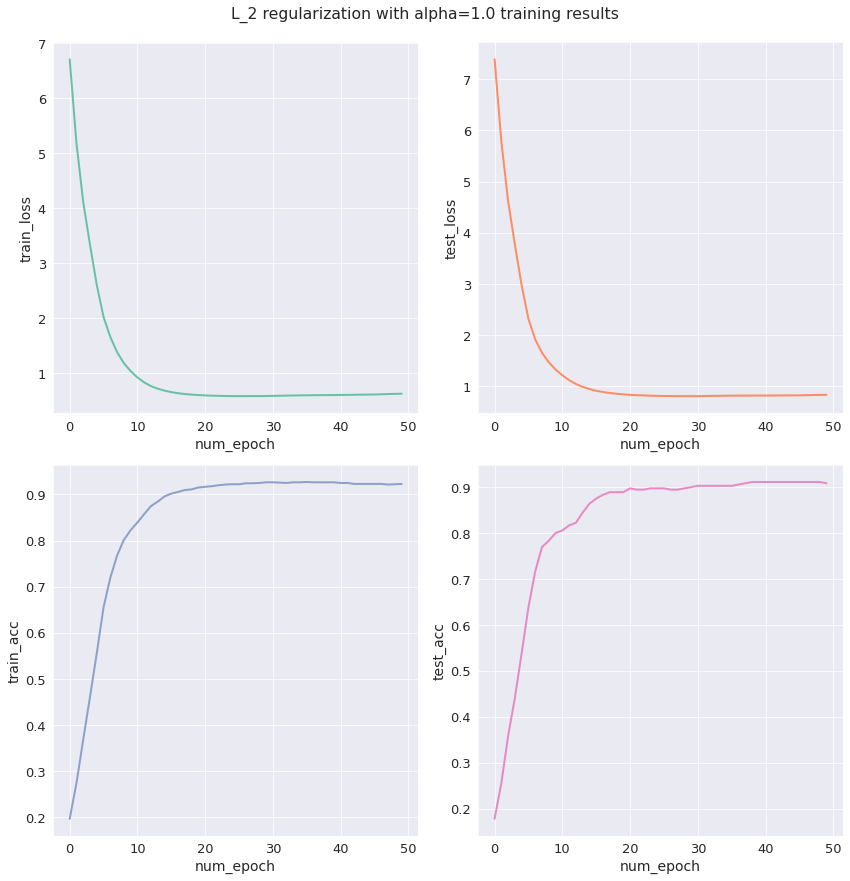

In [ ]:
def plot_result(ax, x, y, xlabel, ylabel, color, linewidth=2):
    ax.plot(x, y, color=color, linewidth=linewidth)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax

train_losses, test_losses = losses
train_accs, test_accs = accs
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12, 12), tight_layout=True)
x = np.arange(config["num_epochs"])
xlabel = "num_epoch"
ax[0][0] = plot_result(ax[0][0], x, train_losses, xlabel, 
                       ylabel="train_loss", color=palette[0], linewidth=2)
ax[0][1] = plot_result(ax[0][1], x, test_losses, xlabel,
                       ylabel='test_loss', color=palette[1], linewidth=2)
ax[1][0] = plot_result(ax[1][0], x, train_accs, xlabel,
                       ylabel='train_acc', color=palette[2], linewidth=2)
ax[1][1] = plot_result(ax[1][1], x, test_accs, xlabel,
                       ylabel='test_acc', color=palette[3], linewidth=2)
fig.suptitle(f"L_{2} regularization with alpha={1.0} training results", y=1.02)

## Dependency of $p$ in $L^p$ regularization

### Hyperparameters

In [ ]:
all_p = [1, 2, 3, 4, 5, 10, 20, 'inf'] 
alpha = 1.0

all_trained_params = {}

all_trained_losses = {}
all_trained_accs = {}
all_tested_losses = {}
all_tested_accs = {}

### training process

In [ ]:
for p in all_p:
    trainer = Trainer(init_params, opt_state, p=p, alpha=alpha)
    trained_params, losses, accs = trainer.train(train_dataloader, config['num_epochs'])
    all_trained_params[str(p)] = trained_params
    train_losses, test_losses = losses
    all_trained_losses[str(p)] = train_losses
    all_tested_losses[str(p)] = test_losses
    train_accs, test_accs = accs
    all_trained_accs[str(p)] = train_accs
    all_tested_accs[str(p)] = test_accs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Histograms

In [ ]:
def make_hists(all_params, list_of_p, name_of_params, kind=None):
    if name_of_params == 'fc1_w':
        i, j = 0, 0
        title = f'Histogram distribution of fc1 weight params for p={list_of_p}'
    elif name_of_params == 'fc1_b':
        i, j = 0, 1
        title = f'Histogram distribution of fc1 bias params for p={list_of_p}'
    elif name_of_params == 'fc2_w':
        i, j = 2, 0
        title = f'Histogram distribution of fc2 weight params for p={list_of_p}'
    elif name_of_params == 'fc2_b':
        i, j = 2, 1
        title = f'Histogram distribution of fc2 bias params for p={list_of_p}'
    else:
        raise KeyError("name_of_params argument must be one of: \'fc1_w\', \'fc1_b\', \'fc2_w\', \'fc2_b\'")

    params_data = {'p': [], 'weights': []}
    for p in list_of_p:
        weights = all_params[str(p)][i][j].reshape(-1).tolist()
        params_data['p'].extend([p for _ in range(len(weights))])
        params_data['weights'].extend(weights)
    pd_params_data = pd.DataFrame.from_dict(params_data)

    if kind is None:
        sns.displot(pd_params_data, x="weights", hue="p", palette='Set2', height=10).set(title=title)

    elif kind == 'kde':
        sns.displot(pd_params_data, x="weights", hue="p", kind='kde', fill=True, palette='Set2', height=10).set(title=title)

    elif kind == 'ecdf':
        sns.displot(pd_params_data, x="weights", hue="p", kind='ecdf', palette='Set2', height=10).set(title=title)

    else:
        raise KeyError("parameter kind must be one of: \'kde\', \'ecdf\', \'None\'")

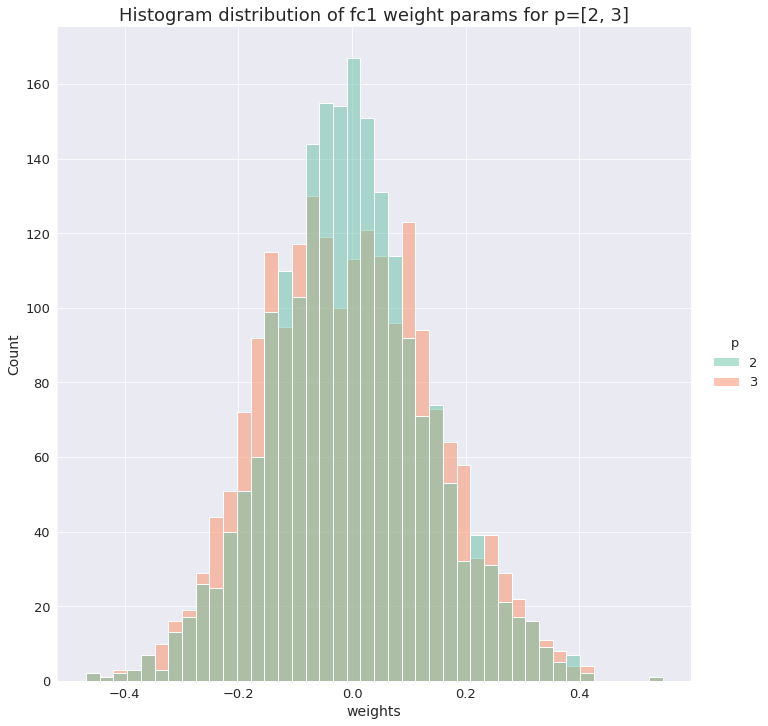

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 3], name_of_params='fc1_w')

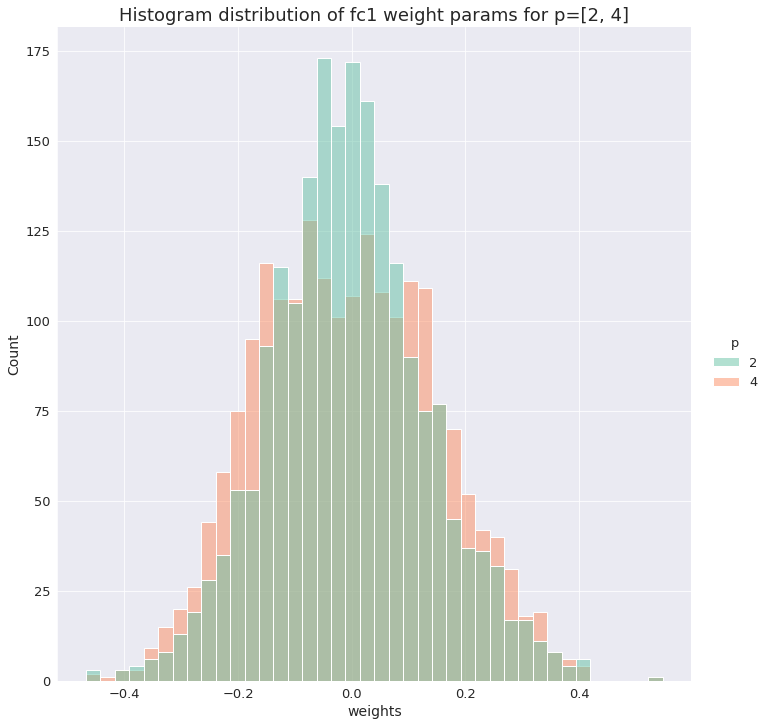

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 4], name_of_params='fc1_w')

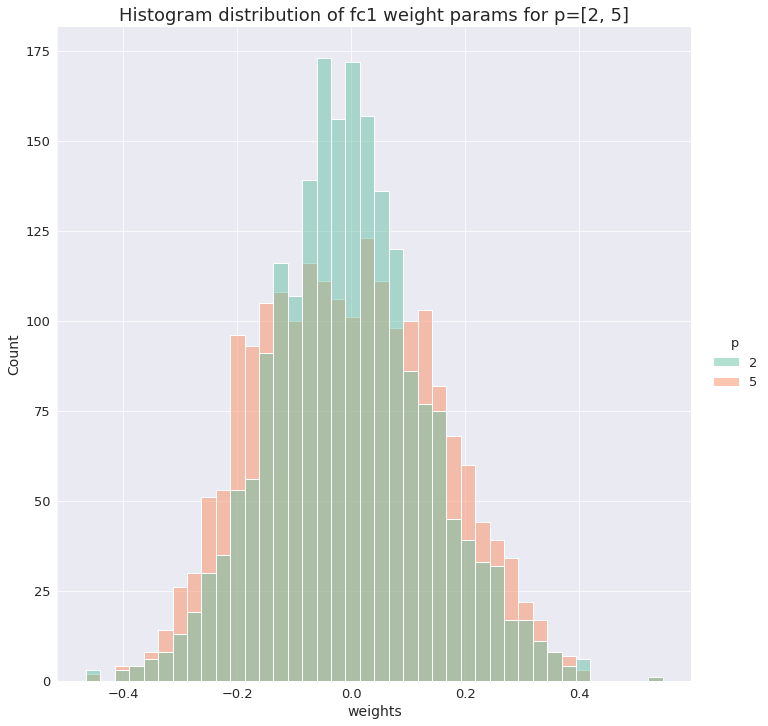

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 5], name_of_params='fc1_w')

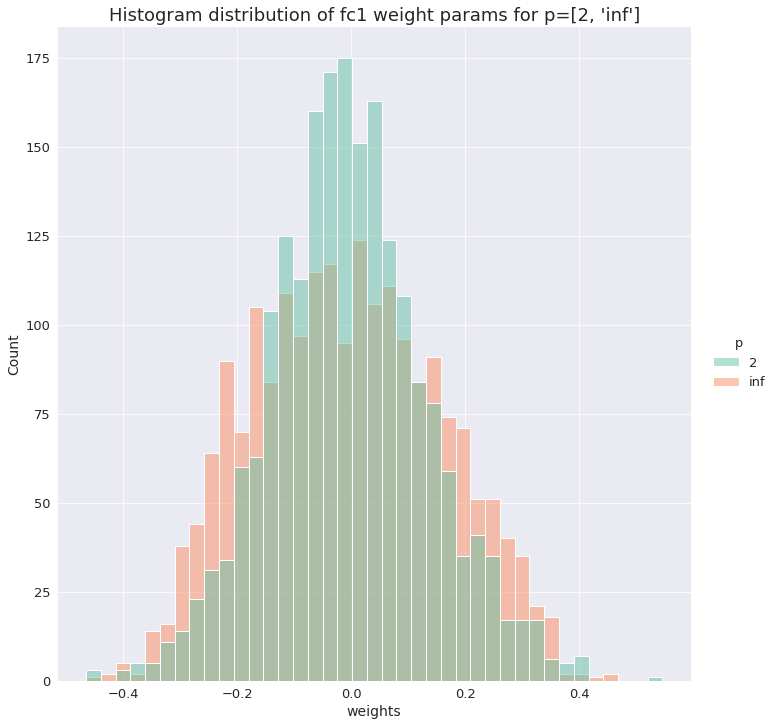

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 'inf'], name_of_params='fc1_w')

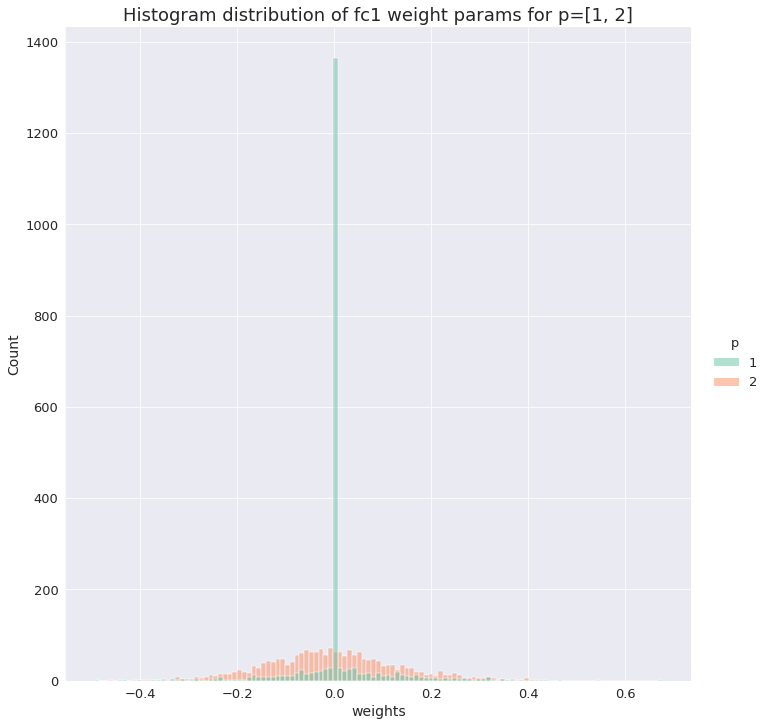

In [ ]:
make_hists(all_trained_params, list_of_p = [1, 2], name_of_params='fc1_w')

### Kernel density estimation

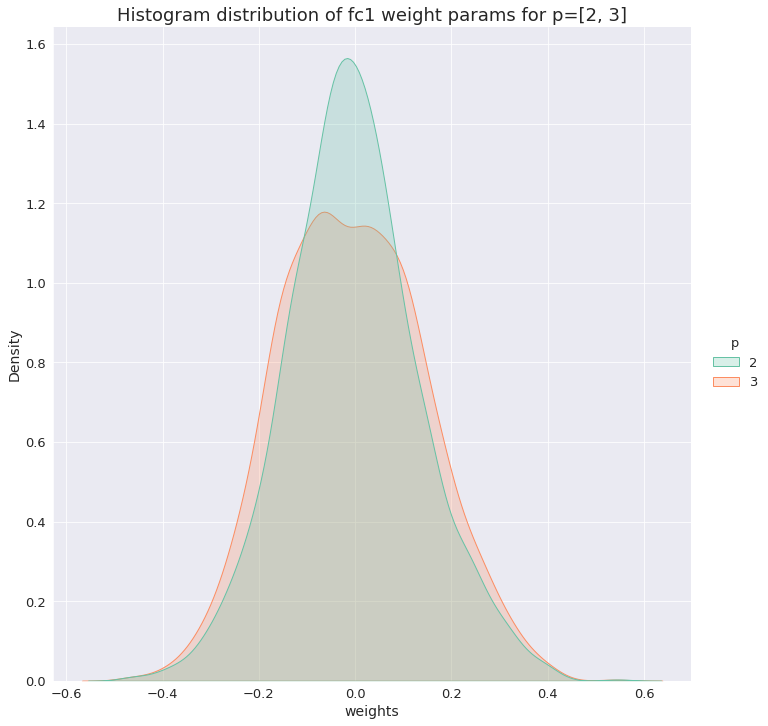

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 3], name_of_params='fc1_w', kind='kde')

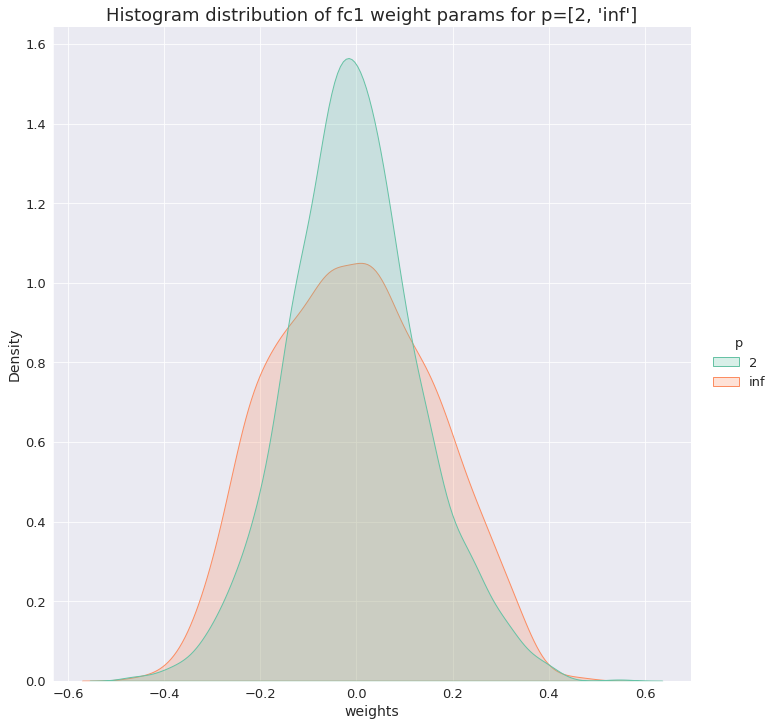

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 'inf'], name_of_params='fc1_w', kind='kde')

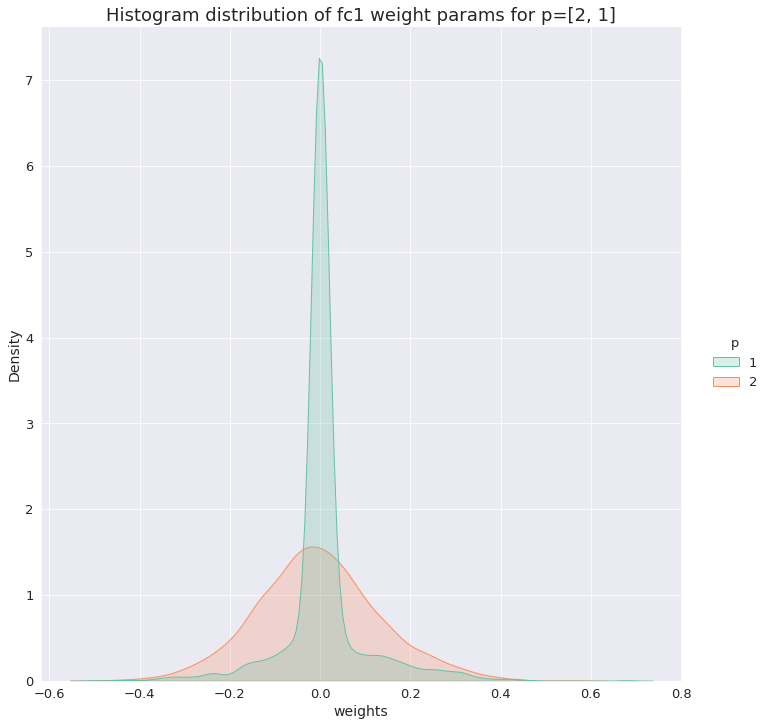

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 1], name_of_params='fc1_w', kind='kde')

### Empirical cumulative distribution

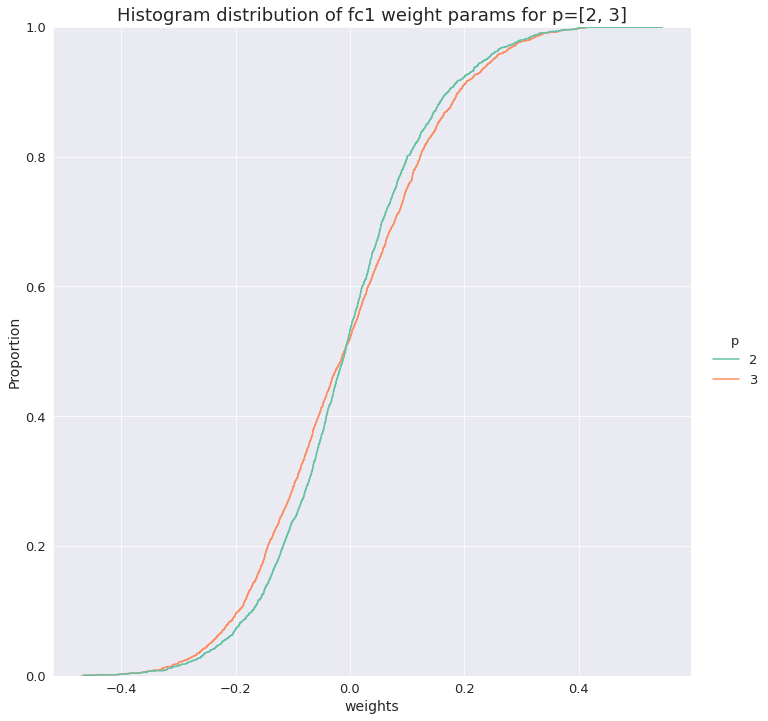

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 3], name_of_params='fc1_w', kind='ecdf')

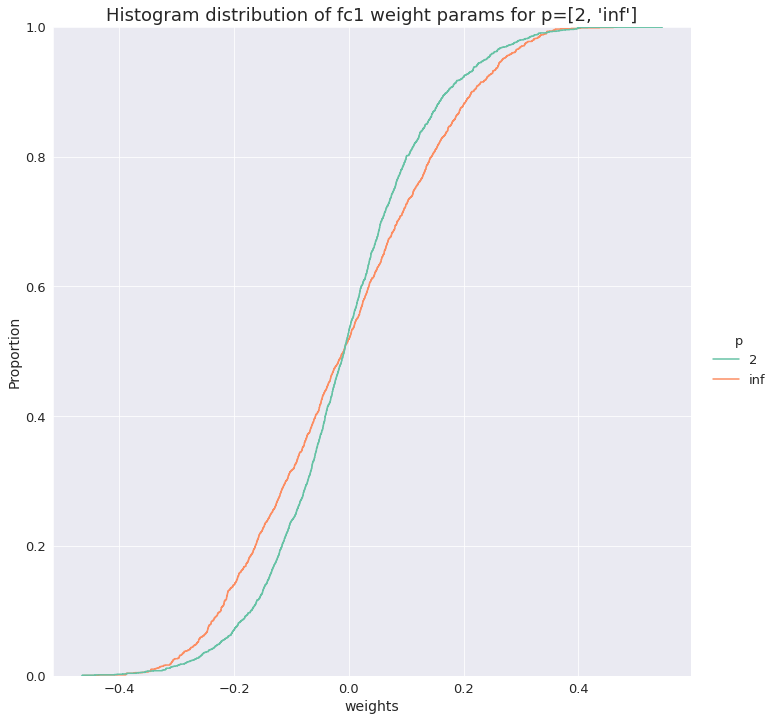

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 'inf'], name_of_params='fc1_w', kind='ecdf')

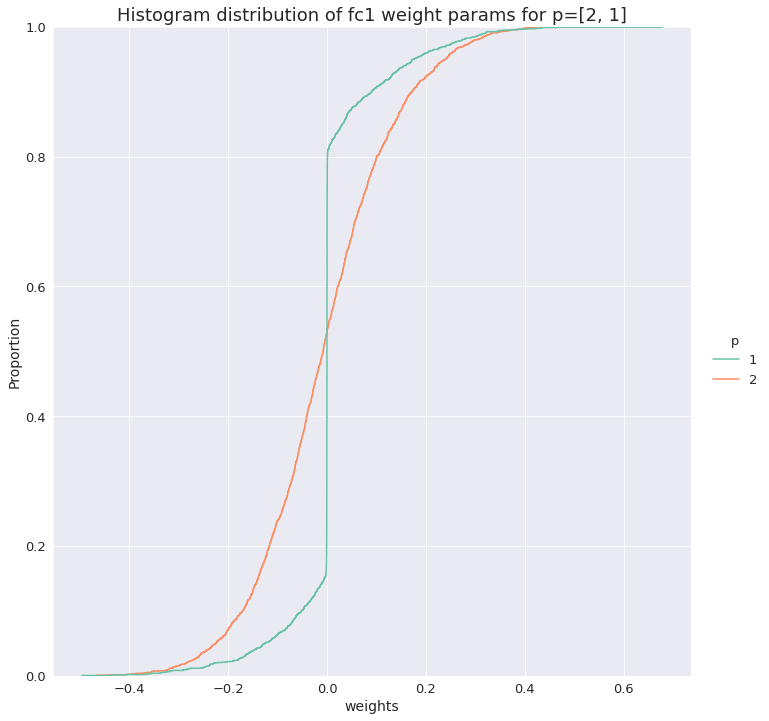

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 1], name_of_params='fc1_w', kind='ecdf')

### different layers dependency

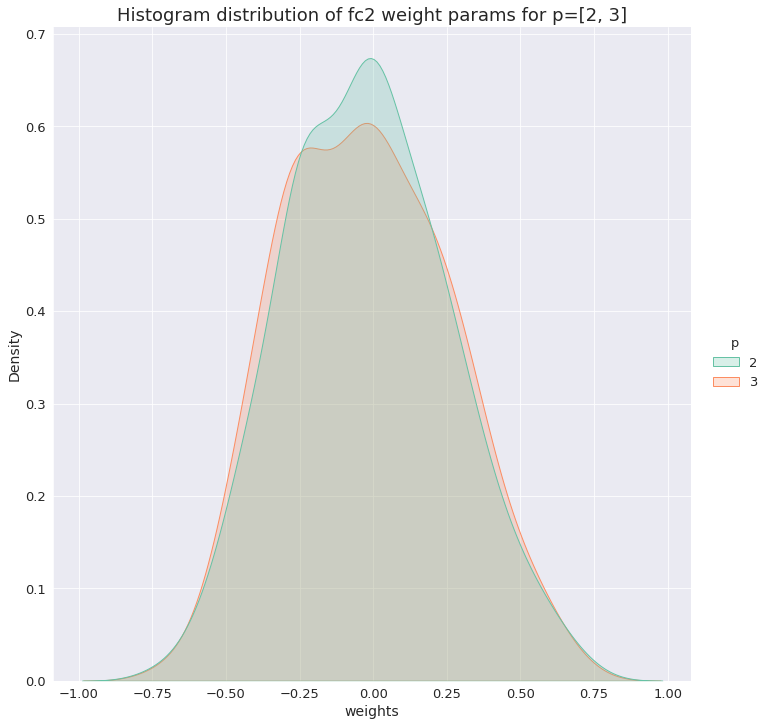

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 3], name_of_params='fc2_w', kind='kde')

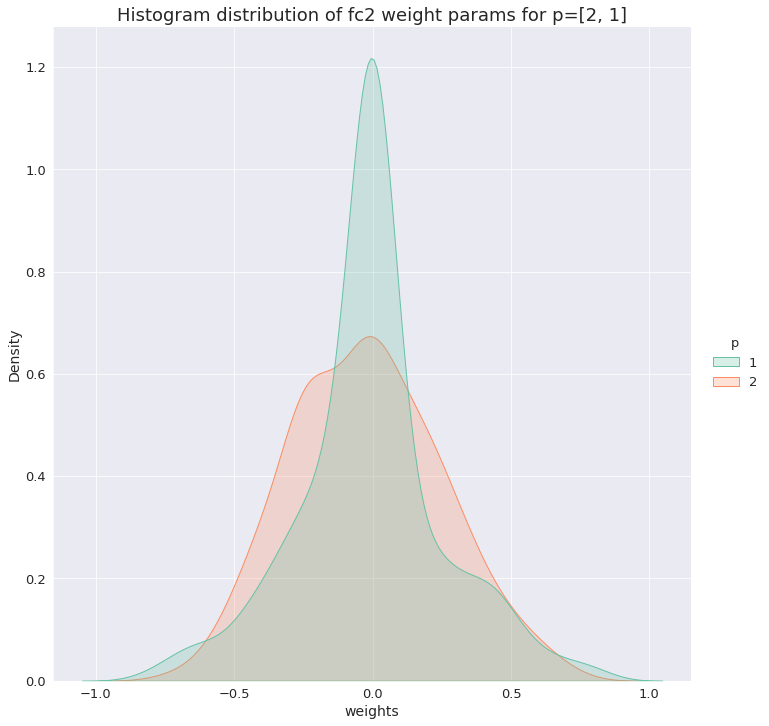

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 1], name_of_params='fc2_w', kind='kde')

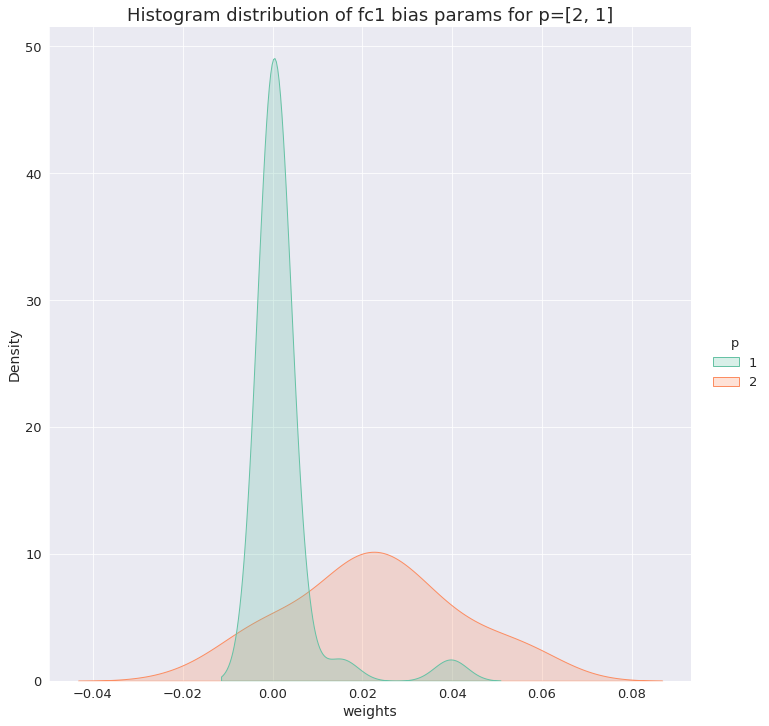

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 1], name_of_params='fc1_b', kind='kde')

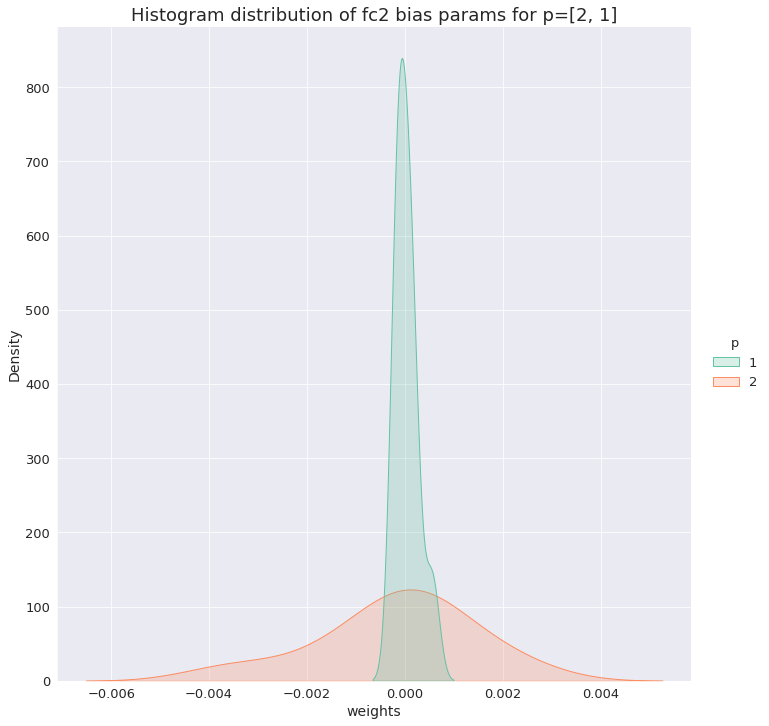

In [ ]:
make_hists(all_trained_params, list_of_p = [2, 1], name_of_params='fc2_b', kind='kde')